In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [2]:
tf.__version__

'2.3.0'

## Dataset -- Cifar10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)


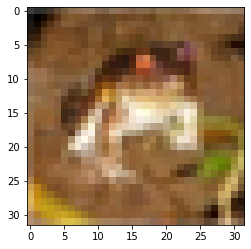

In [5]:
plt.imshow(x_train[0])
plt.show()

In [6]:
x_train[0].shape

(32, 32, 3)

In [7]:
y_train[0]

array([6], dtype=uint8)

In [8]:
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (50000, 1)
y_test shape:  (10000, 1)


In [9]:
print(y_train[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


[0 1 2 3 4 5 6 7 8 9]
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


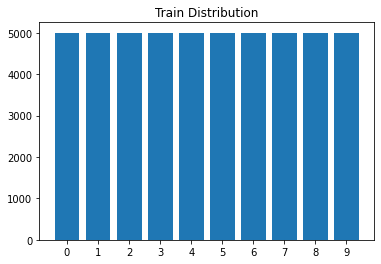

In [10]:
label, counts = np.unique(y_train, return_counts=True)
print(label)
print(counts)

plt.bar(label, counts, tick_label=label)
plt.title("Train Distribution")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                               test_size=0.2,
                               random_state=2,
                               stratify=y_train)

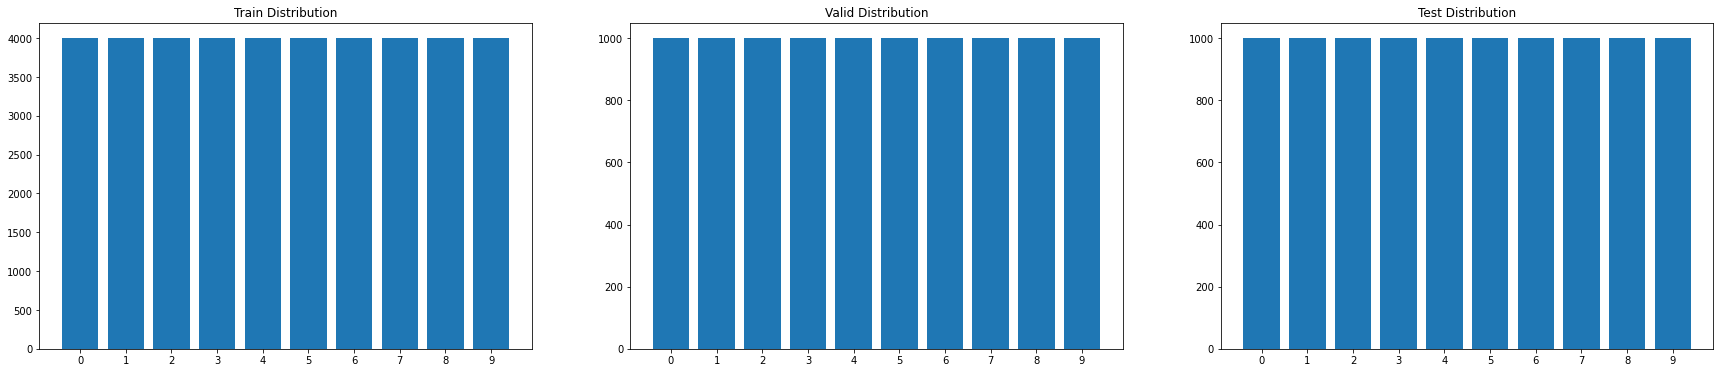

In [13]:
data_list = [y_train, y_valid, y_test]
data_types = ["Train", "Valid", "Test"]

plt.figure(figsize=(30, 6))
for i in range(3):
  label, counts = np.unique(data_list[i], return_counts=True)

  plt.subplot(1, 3, i+1)
  plt.bar(label, counts, tick_label=label)
  plt.title(data_types[i]+" Distribution")
plt.show()

## Data Preprocessing

In [14]:
print("x_train type: ", x_train.dtype)
print("x_train max: ", x_train.max())
print("x_train min: ", x_train.min())

x_train type:  uint8
x_train max:  255
x_train min:  0


#### min_max normalization

In [15]:
x_train = x_train.astype("float32")/255
x_valid = x_valid.astype("float32")/255
x_test = x_test.astype("float32")/255

In [16]:
print("x_train type: ", x_train.dtype)
print("x_train max: ", x_train.max())
print("x_train min: ", x_train.min())

x_train type:  float32
x_train max:  1.0
x_train min:  0.0


#### Category -- One-Hot Encoding

In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
y_train_one = to_categorical(y_train)
y_valid_one = to_categorical(y_valid)
y_test_one = to_categorical(y_test)

In [19]:
print("y_train type: ", y_train.dtype)
print("y_train shape: ", y_train.shape)
print("preprocessing".center(30, "-"))
print("y_train_one type: ", y_train_one.dtype)
print("y_train_one shape: ", y_train_one.shape)

y_train type:  uint8
y_train shape:  (40000, 1)
--------preprocessing---------
y_train_one type:  float32
y_train_one shape:  (40000, 10)


In [20]:
y_train[:3]

array([[2],
       [2],
       [8]], dtype=uint8)

In [21]:
y_train_one[:3]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

## Modeling

In [22]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [23]:
x_train[0].shape

(32, 32, 3)

In [24]:
num_classes = y_train_one[0].shape[0]
num_classes

10

In [25]:
print(x_train[0].shape[0])
print(" ")
print(x_train[0].shape[1])

32
 
32


In [26]:

inputs = layers.Input(shape=(x_train[0].shape[0], x_train[0].shape[1], 3))

x = layers.Conv2D(filters=32, kernel_size=(3, 3))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPool2D((2, 2))(x)


x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)       

In [28]:
model_weight = model.variables
# model_weight = model.get_weights()

In [29]:
# model_weight

In [30]:
# model_weight[0].shape

In [31]:
from tensorflow.keras import callbacks

In [32]:
model_dir = './model-logs'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [33]:
lr = 0.001
optimizer = optimizers.Adam(lr, decay=True)
model.compile(loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=['accuracy'])

In [34]:
num_epoch = 10
batch_size = 64
history = model.fit(x_train, y_train_one,
            batch_size=batch_size,
            epochs=num_epoch,
            validation_data=(x_valid, y_valid_one),
            callbacks=callbacks_list
            )

Epoch 1/10
625/625 [==============================] - 9s 14ms/step - loss: 2.0545 - accuracy: 0.2863 - val_loss: 1.9944 - val_accuracy: 0.3128
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 1.9443 - accuracy: 0.3302 - val_loss: 1.9346 - val_accuracy: 0.3279
Epoch 3/10
625/625 [==============================] - 8s 12ms/step - loss: 1.9152 - accuracy: 0.3416 - val_loss: 1.9137 - val_accuracy: 0.3389
Epoch 4/10
625/625 [==============================] - 8s 12ms/step - loss: 1.8980 - accuracy: 0.3476 - val_loss: 1.8998 - val_accuracy: 0.3442
Epoch 5/10
625/625 [==============================] - 8s 12ms/step - loss: 1.8858 - accuracy: 0.3543 - val_loss: 1.8891 - val_accuracy: 0.3495
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 1.8761 - accuracy: 0.3566 - val_loss: 1.8813 - val_accuracy: 0.3542
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 1.8690 - accuracy: 0.3605 - val_loss: 1.8745 - val_accuracy: 0.3577

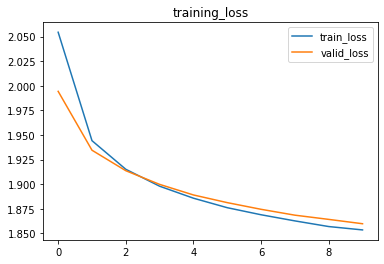

In [35]:
plt.plot(np.arange(num_epoch), history.history['loss'], label="train_loss")
plt.plot(np.arange(num_epoch), history.history['val_loss'], label="valid_loss")
plt.legend(loc='best')
plt.title('training_loss')
plt.show()

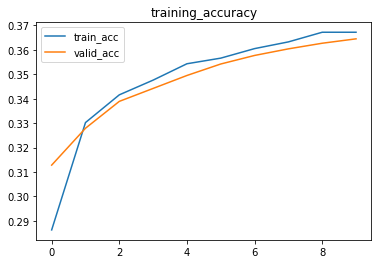

In [36]:
plt.plot(np.arange(num_epoch), history.history['accuracy'], label="train_acc")
plt.plot(np.arange(num_epoch), history.history['val_accuracy'], label="valid_acc")
plt.legend(loc='best')
plt.title('training_accuracy')
plt.show()

In [37]:
model.save("model_test.h5")

In [38]:
model = load_model("model_test.h5")

## Prediction

In [39]:
y_test_predprob = model.predict(x_test)
print(y_test_predprob[:3])

[[0.05820967 0.05279016 0.16307555 0.1583244  0.12336198 0.14847536
  0.15626025 0.05366375 0.04785853 0.03798038]
 [0.10931896 0.32550728 0.04461003 0.16890042 0.00682638 0.02824872
  0.00146867 0.03198486 0.1696563  0.11347834]
 [0.11688849 0.16901502 0.07935328 0.13327037 0.01438443 0.05970888
  0.00410428 0.05019001 0.28459898 0.08848633]]


In [40]:
y_test_predprob.shape

(10000, 10)

In [41]:
y_test_predprob.shape

(10000, 10)

In [42]:
y_test_pred = y_test_predprob.argmax(-1)
print("y_test_pred shape: ", y_test_pred.shape)
print(y_test_pred[:3])

y_test_pred shape:  (10000,)
[2 1 8]


In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [44]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")
print("confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

accuracy_score: 0.374
confusion matrix: 
 [[482 134  28  36   7  20  25  50 169  49]
 [ 40 624   6  47   7  31  57  24  46 118]
 [141  78 121  84 155  85 174  86  47  29]
 [ 48  89  31 231  79 184 177  84  30  47]
 [ 51  58  77  60 270  70 258 107  27  22]
 [ 30  57  65 109 110 313 150  89  47  30]
 [ 17  74  41 119  96  51 524  37   2  39]
 [ 24  69  19  82 116 115  77 386  32  80]
 [178 192  10  59   3  45   5  23 400  85]
 [ 39 346  10  56   4  12  42  43  62 386]]


In [45]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


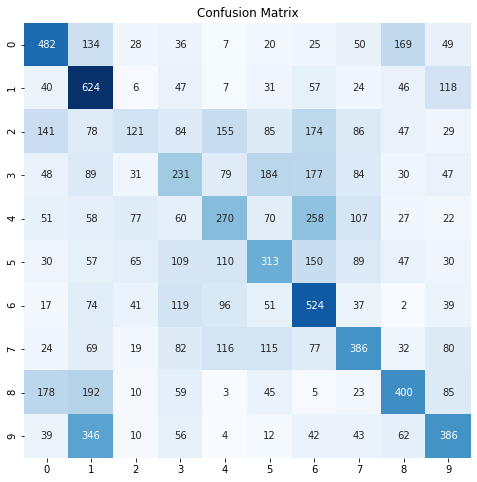

In [46]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.show()